In [1]:
# 0013, 0018, 0021, 0023

## Welch's method
 - http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.welch.html
 - https://en.wikipedia.org/wiki/Welch%27s_method
 - Estimator of power spectrum of a discrete, finite signal that reduces noise in the estimated power spectra compared to the periodogram.

Recipe:
 - Break time-series into overlapping intervals called 'frames'
 - Apply a window to each individual frame
 - Perform dFT on each frame, square the result
 - Average magnitude of the components to get estimate of total dFT
 - The result is an array of power measurements vs. frequency 'bin'

In [3]:
from scipy.signal import welch
directory = '/home/preston/Desktop/Science/Research/cancer_cells/data/7-10-2016/'
file_name = directory + 'HCT116_0000'

In [9]:
data = rp.get_data_raw(file_name)
fs = 250000  # Sampling frequency of data
f, Pxx = welch(data[:,1], fs=250000, nperseg = 2056)

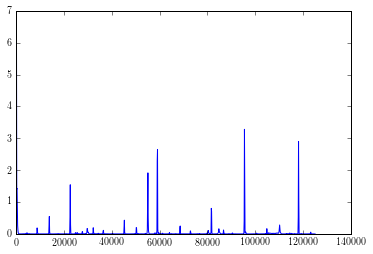

In [10]:
plt.plot(f, Pxx)
plt.show()

# Butterworth low pass filter
 - http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
 - https://en.wikipedia.org/wiki/Butterworth_filter
 - A low-pass filter.

 - Create a Butterworth filter using scipy.signal.butter
 - Pass the Butterworth filter to scipy.signal.lfilter
 
### Arguments:
 - N: Order of the Butterworth filter
 - Wn: The frequency component at which the gain is reduced to 1/sqrt(2) (the -3 dB point). Normalized for digital signals, where 1.0 is the Nyquist frequency (half the sampling frequency).
 - btype: 'high' or 'low' (low-pass or high-pass)
 - 

In [28]:
from scipy.signal import butter, lfilter, welch
directory = '/home/preston/Desktop/Science/Research/cancer_cells/data/7-10-2016/'
file_name = directory + 'HCT116_0000'

In [21]:
data = rp.get_data_raw(file_name)

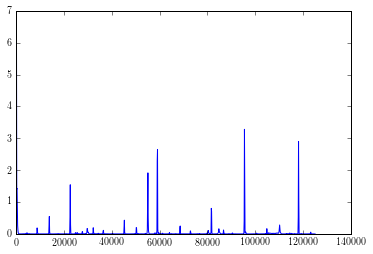

In [49]:
fs = 250000.  # Sampling frequency of data
f, Pxx = welch(data[:,1], fs=fs, nperseg = 2056)
plt.plot(f, Pxx)
plt.show()

In [85]:
cutoff = 10000.
nyquist = fs/2.
Wn = cutoff/nyquist
b, a = butter(N=5, Wn=Wn, btype='low', analog=False)
filtered_data = lfilter(b, a, data[:,1])

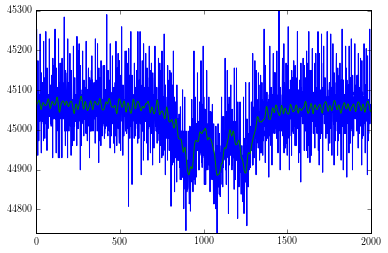

In [86]:
xi=156000
xf=158000
plt.plot(data[xi:xf,1])
plt.plot(filtered_data[xi:xf])

plt.ylim(data[xi:xf,1].min(), data[xi:xf,1].max())
plt.show()

In [94]:
print data[:,0].reshape(-1,1).shape

(2225000, 1)


In [95]:
print filtered_data.shape

(2225000,)


In [96]:
new_data = np.hstack((data[:,0].reshape(-1,1), filtered_data[:].reshape(-1,1)))
print new_data.shape

(2225000, 2)


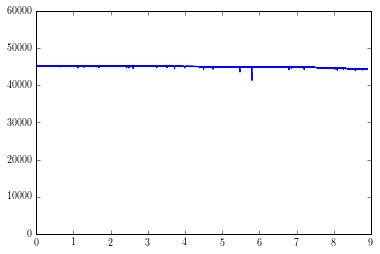

In [97]:
plt.plot(new_data[:,0], new_data[:,1])
plt.show()

# Image processing

In [2]:
import optical_imaging as oi
import oi_file
import numpy as np

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline

reload(oi)

<module 'optical_imaging' from 'optical_imaging.pyc'>

In [45]:
file_directory='/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/oi_rp/vid/'
file_name=file_directory + 'section.mp4'
filepath_bvi = '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/oi_rp/bvi/HCT-116_pr0005_0000.bvi'
vid = oi_file.open_video_connection(file_name)

## Image preprocessing

In [46]:
from scipy.ndimage.filters import gaussian_filter
reload(oi)

def preprocess_frame(frame, alpha, beta):
    new_frame = frame[:,:]
    
    
    # Contrast and brightness adjust
    new_frame = oi.change_frame_contrast(new_frame, alpha, beta)
    
    return new_frame

In [56]:
alpha = 1.5#3.25#10.0
beta = 0.25#.01
threshold_difference = .0225#.03
cluster_threshold = 100

frame_template = oi_file.get_frame_vid(vid, 0)
frame = oi_file.get_frame_vid(vid, 200)

frame_template_processed = preprocess_frame(frame_template, alpha, beta)
frame_processed = preprocess_frame(frame, alpha, beta)

0 clusters =  0


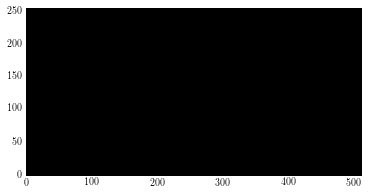

20 clusters =  0


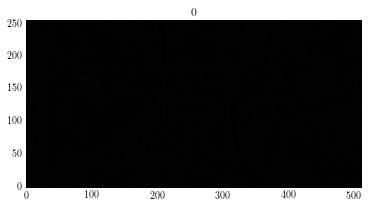

40 clusters =  0


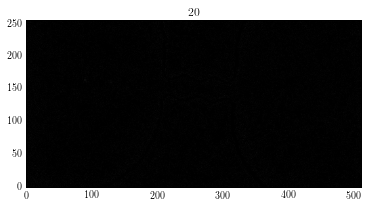

60 clusters =  0


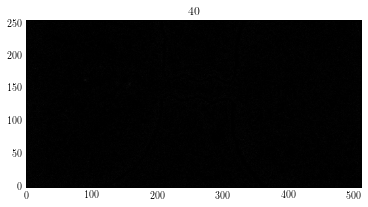

80 clusters =  0


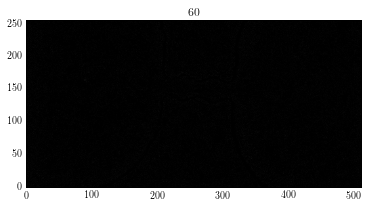

100 clusters =  0


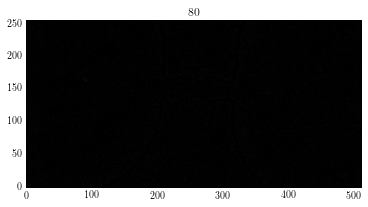

120 clusters =  0


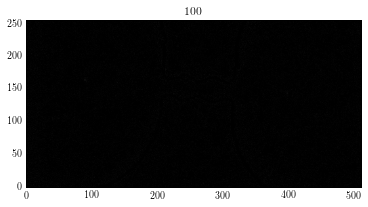

140 clusters =  0


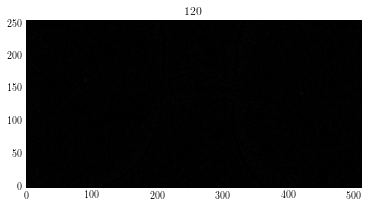

160 clusters =  0


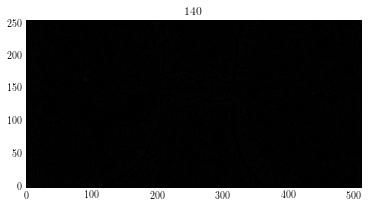

180 clusters =  0


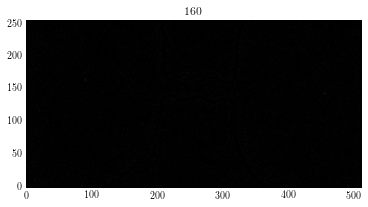

200 clusters =  0


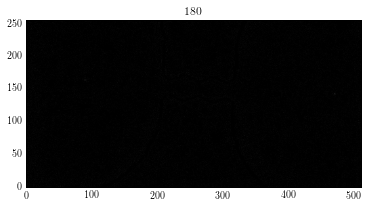

220 clusters =  0


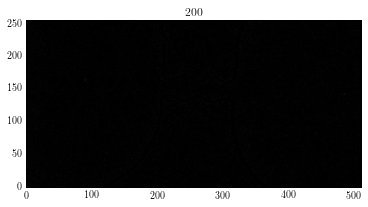

240 clusters =  0


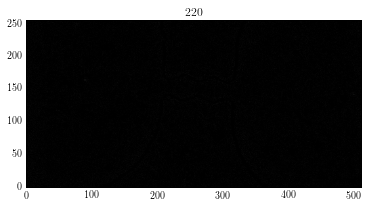

260 clusters =  0


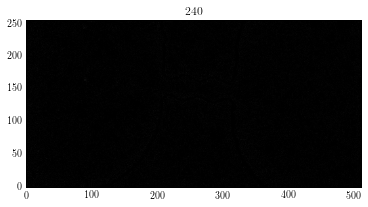

280 clusters =  1


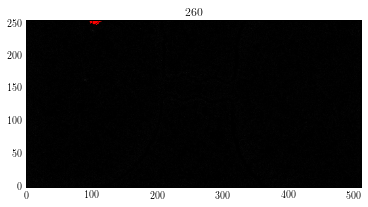

300 clusters =  1


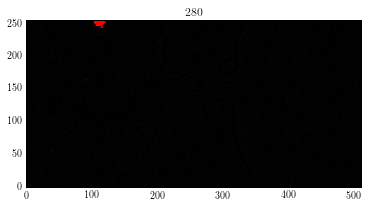

320 clusters =  1


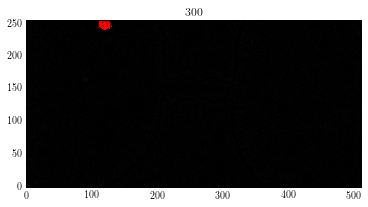

340 clusters =  1


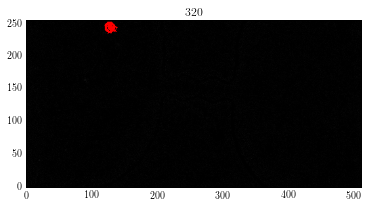

360 clusters =  1


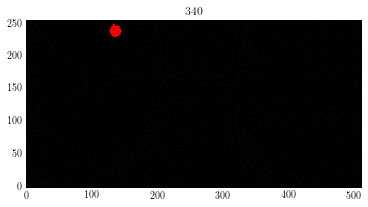

380 clusters =  1


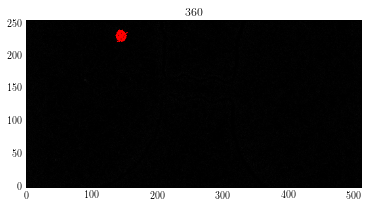

400 clusters =  1


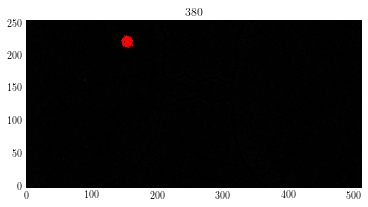

420 clusters =  1


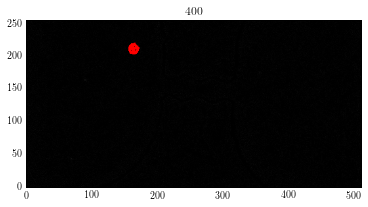

440 clusters =  1


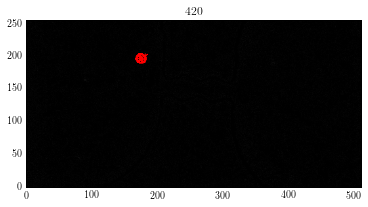

460 clusters =  1


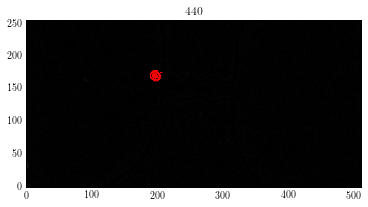

480 clusters =  2


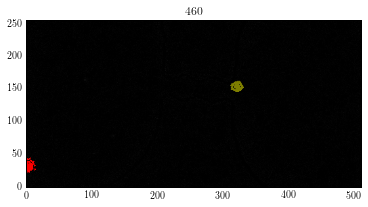

500 clusters =  2


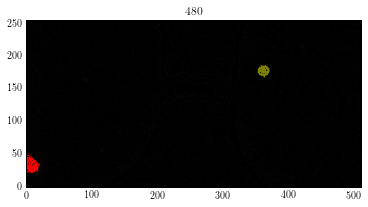

520 clusters =  2


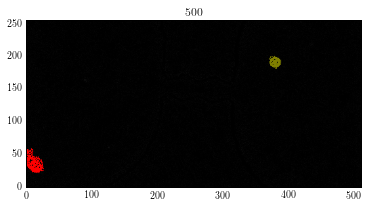

540 clusters =  2


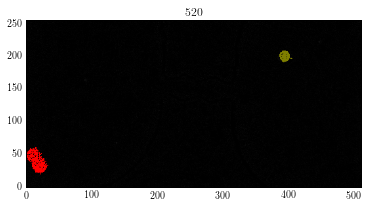

560 clusters =  2


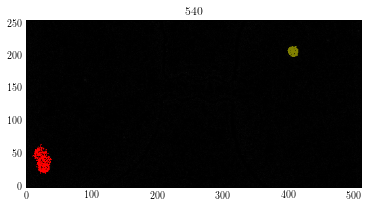

580 clusters =  2


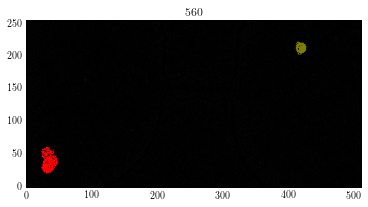

600 clusters =  2


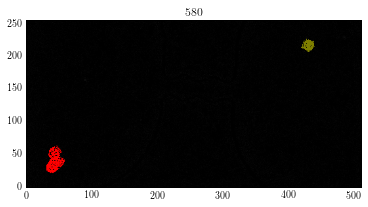

620 clusters =  2


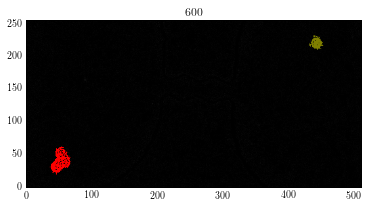

640 clusters =  2


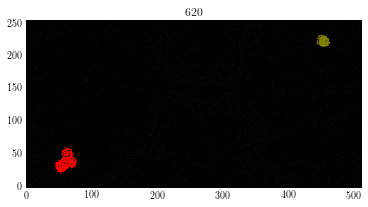

660 clusters =  2


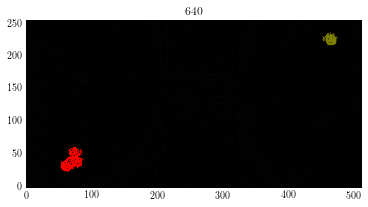

680 clusters =  2


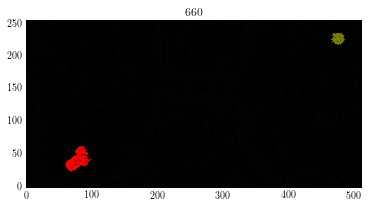

700 clusters =  2


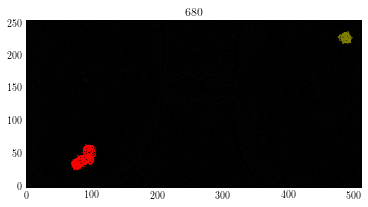

720 clusters =  2


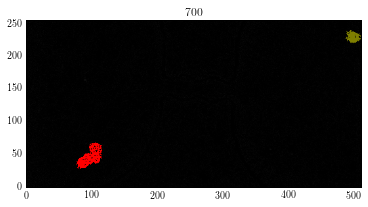

740 clusters =  2


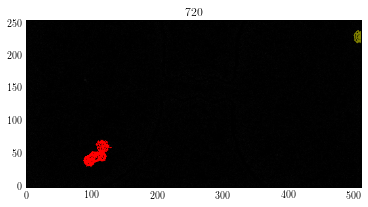

760 clusters =  1


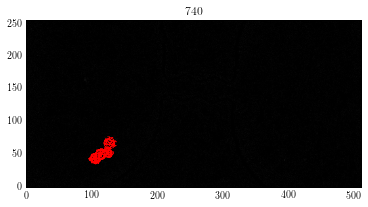

780 clusters =  1


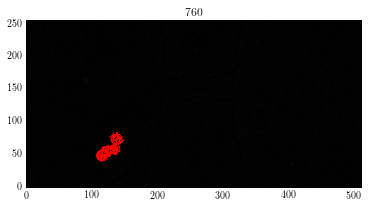

800 clusters =  2


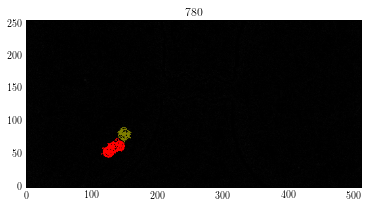

820 clusters =  2


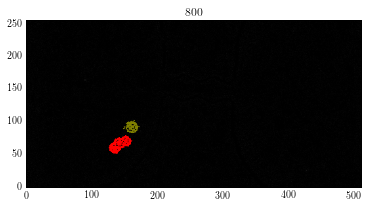

840 clusters =  2


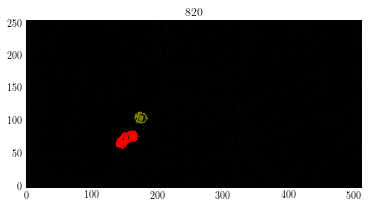

860 clusters =  2


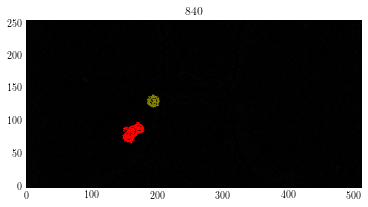

880 clusters =  2


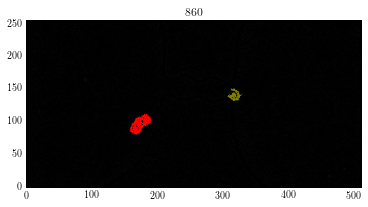

900 clusters =  2


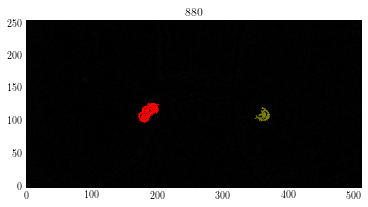

920 clusters =  2


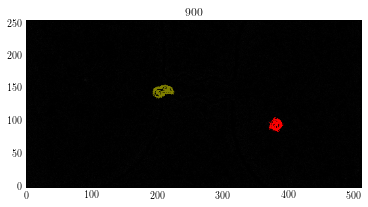

940 clusters =  2


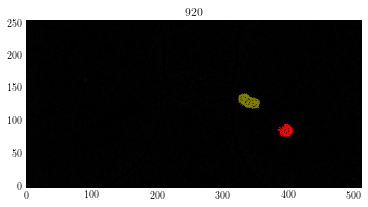

960 clusters =  2


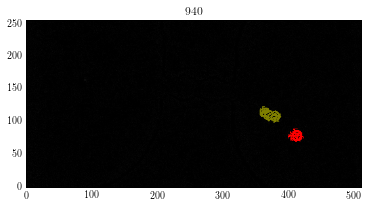

980 clusters =  2


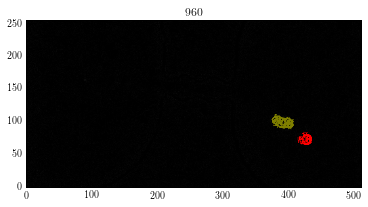

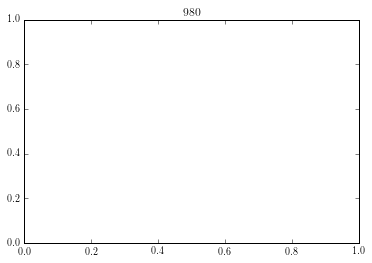

In [57]:
frame_template = oi_file.get_frame_vid(vid, 0)
frame_template_processed = preprocess_frame(frame_template, alpha, beta)
for f in range(0,1000,20):
    
    
    frame = oi_file.get_frame_vid(vid, f)

    
    frame_processed = preprocess_frame(frame, alpha, beta)
    negative_frame = abs(frame_processed - frame_template_processed)
   

    highlighted_frame = np.empty((negative_frame.shape[0], negative_frame.shape[1], 3))

    for i in range(negative_frame.shape[0]):
        for j in range(negative_frame.shape[1]):
            highlighted_frame[i,j,0] = negative_frame[i,j]
            highlighted_frame[i,j,1] = negative_frame[i,j]
            highlighted_frame[i,j,2] = negative_frame[i,j]
            
    clusters = oi.find_clusters_percentage_based(frame_processed, frame_template_processed,\
                                             threshold_difference = threshold_difference, \
                                             cluster_threshold = cluster_threshold)
    print f, 'clusters = ', len(clusters)
    for k, cluster in enumerate(clusters):
        for point in cluster:
            highlighted_frame[point[0], point[1],0] = 1.*(len(clusters)-k)/len(clusters)
            highlighted_frame[point[0], point[1],1] = 1.*k/len(clusters)
            highlighted_frame[point[0], point[1],2] = 0
    #plt.imshow(frame_processed, cmap = 'gray', vmin = 0, vmax = 1)
    plt.imshow(highlighted_frame, origin = 'lower', vmin = 0, vmax = 1)
    plt.show()
    plt.title(str(f))

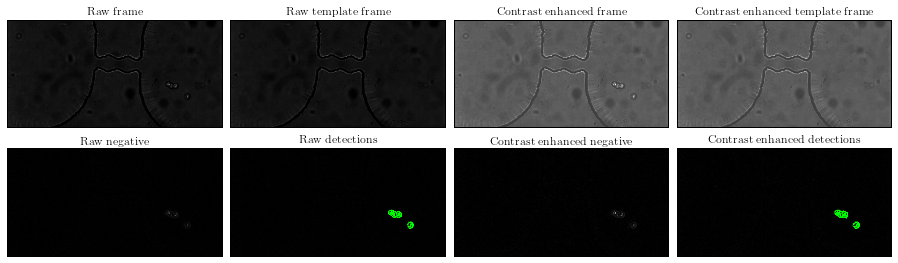

In [51]:
# Set up figure
fig = plt.figure(figsize = (16,4))
plt.subplots_adjust(top = .945)
gs = gridspec.GridSpec(2,4)
gs.update(wspace = 0, hspace = .2)

for i,g in enumerate(gs):
    plt.subplot(gs[i])
    plt.xticks([])
    plt.yticks([])

# Plot unprocessed frames

clusters = oi.find_clusters_percentage_based(frame, frame_template,\
                                             threshold_difference = threshold_difference)



negative_frame = abs(frame-frame_template)

highlighted_frame = np.empty((negative_frame.shape[0], negative_frame.shape[1], 3))

for i in range(negative_frame.shape[0]):
    for j in range(negative_frame.shape[1]):
        highlighted_frame[i,j,:] = negative_frame[i,j]
        
for cluster in clusters:
    for point in cluster:
        highlighted_frame[point[0], point[1],0] = 0
        highlighted_frame[point[0], point[1],1] = 1.
        highlighted_frame[point[0], point[1],2] = 0

plt.subplot(gs[0])

plt.imshow(frame, vmin = 0, vmax = 1, cmap = 'gray', origin = 'lower')
plt.title('Raw frame')

plt.subplot(gs[1])
plt.imshow(frame_template, vmin = 0, vmax = 1, cmap = 'gray', origin = 'lower')
plt.title('Raw template frame')

plt.subplot(gs[4])
plt.imshow(negative_frame, vmin = 0, vmax = 1, cmap = 'gray', origin = 'lower')
plt.title('Raw negative')

plt.subplot(gs[5])
plt.imshow(highlighted_frame, origin = 'lower')
plt.title('Raw detections')

# Plot processed frames
clusters = oi.find_clusters_percentage_based(frame_processed, frame_template_processed,\
                                             threshold_difference = threshold_difference, \
                                             cluster_threshold = 20)
negative_frame = abs(frame_processed - frame_template_processed)

highlighted_frame = np.empty((negative_frame.shape[0], negative_frame.shape[1], 3))

for i in range(negative_frame.shape[0]):
    for j in range(negative_frame.shape[1]):
        highlighted_frame[i,j,0] = negative_frame[i,j]
        highlighted_frame[i,j,1] = negative_frame[i,j]
        highlighted_frame[i,j,2] = negative_frame[i,j]
for cluster in clusters:
    for point in cluster:
        highlighted_frame[point[0], point[1],0] = 0
        highlighted_frame[point[0], point[1],1] = 1.
        highlighted_frame[point[0], point[1],2] = 0

plt.subplot(gs[2])
plt.imshow(frame_processed, vmin = 0, vmax = 1, cmap = 'gray', origin = 'lower')
plt.title('Contrast enhanced frame')

plt.subplot(gs[3])
plt.imshow(frame_template_processed, vmin = 0, vmax = 1, cmap = 'gray', origin = 'lower')
plt.title('Contrast enhanced template frame')

plt.subplot(gs[6])
plt.imshow(negative_frame, vmin = 0, vmax = 1, cmap = 'gray', origin = 'lower')
plt.title('Contrast enhanced negative')

plt.subplot(gs[7])
plt.imshow(highlighted_frame, origin = 'lower')
plt.title('Contrast enhanced detections')

#plt.savefig('./raw-contrasted_comparison.png', dpi = 300)

plt.show()

# File conversions

In [61]:
import resistive_pulse as rp
import rp_file
reload(rp)
reload(rp_file)
import csv
from array import array
import struct
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from os import listdir
from os.path import isfile, join

# Directory atf to bts

In [3]:
path = '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/rp/atf/'
files = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
print files

['/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/rp/atf/HCT116_pr0006_0000.atf', '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/rp/atf/HCT116_pr0015_0000.atf', '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/rp/atf/HCT116_pr0012_0000.atf', '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/rp/atf/HCT116_pr0009_0000.atf', '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/rp/atf/HCT116_pr0003_0000.atf', '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/rp/atf/HCT116_pr0015_0001.atf', '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/rp/atf/HCT116_pr0015_0002.atf']


In [4]:
for i, f in enumerate(files):
    rp_file.atf_to_bts(f, 1)

# Single file atf to bts

In [66]:
import rp_file
reload(rp_file)

<module 'rp_file' from 'rp_file.pyc'>

In [67]:
directory = '/home/preston/Desktop/Science/Research/precipitation/atf/'
file_name = '2016_08_23_Conical_pore_0_1MKCl_sweep_Co_075uM_PBS_0000.atf'
file_path = directory + file_name

In [68]:
rp_file.atf_to_bts(file_path)

num_voltages =  41


In [69]:
reload(rp_file)

<module 'rp_file' from 'rp_file.pyc'>

# Split bts

In [3]:
import resistive_pulse as rp
import rp_file
reload(rp)
reload(rp_file)

<module 'rp_file' from 'rp_file.pyc'>

In [6]:
file_path = '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/rp/bts/HCT116_pr0015_0001.bts'

In [7]:
rp_file.split_file(file_path, 3)

[[  0.00000000e+00   4.98739000e+04]
 [  4.00000000e-06   4.99105000e+04]
 [  8.00000000e-06   4.98678000e+04]
 [  1.20000000e-05   4.98495000e+04]
 [  1.60000000e-05   4.98678000e+04]
 [  2.00000000e-05   4.98434000e+04]
 [  2.40000000e-05   4.98922000e+04]
 [  2.80000000e-05   4.99105000e+04]
 [  3.20000000e-05   4.98678000e+04]
 [  3.60000000e-05   4.98495000e+04]]
[[    80.216664  49800.7     ]
 [    80.216668  49788.5     ]
 [    80.216672  49739.6     ]
 [    80.216676  49873.9     ]
 [    80.21668   49788.5     ]
 [    80.216684  49782.4     ]
 [    80.216688  49751.9     ]
 [    80.216692  49794.6     ]
 [    80.216696  49800.7     ]
 [    80.2167    49751.9     ]]
[[   160.433328  49538.2     ]
 [   160.433332  49727.4     ]
 [   160.433336  49684.7     ]
 [   160.43334   49654.2     ]
 [   160.433344  49617.6     ]
 [   160.433348  49666.4     ]
 [   160.433352  49672.5     ]
 [   160.433356  49617.6     ]
 [   160.43336   49587.1     ]
 [   160.433364  49648.1     ]]


# .mp4 to .bvi

In [47]:
import optical_imaging as oi
import oi_file
reload(oi_file)
reload(oi)

<module 'optical_imaging' from 'optical_imaging.pyc'>

In [58]:
directory = '/home/preston/Desktop/Science/Research/cancer_cells/data/8-18-2016/oi_rp/vid/'
filepath = directory + 'section.mp4'

output_filepath = filepath.split('.')[0]+'.bvi'

oi_file.save_oi_file(filepath, output_filepath, alpha = 1.5, beta = .25)

frame 0 out of 1010
frame 100 out of 1010
frame 200 out of 1010
frame 300 out of 1010
frame 400 out of 1010
frame 500 out of 1010
frame 600 out of 1010
frame 700 out of 1010
frame 800 out of 1010
frame 900 out of 1010
frame 1000 out of 1010


# Logistic regression predict accepted/rejected events

In [1]:
import numpy as np
import resistive_pulse as rp
import rp_predictor
import sys
from os import listdir
from os.path import isfile, join

In [2]:
train_events_file_path = '/home/preston/Desktop/Science/Research/pore_stats/qt_app/ML/training_data/'
file_paths = [train_events_file_path + f for f in listdir(train_events_file_path) if isfile(join(train_events_file_path, f))]
print len(file_paths)

25


In [3]:
reload(rp_predictor)
predictor = rp_predictor.RPPredictor()
predictor.load_training_files(file_paths)

loading file  0 out of  25
loading file  1 out of  25
loading file  2 out of  25
loading file  3 out of  25
loading file  4 out of  25
loading file  5 out of  25
loading file  6 out of  25
loading file  7 out of  25
loading file  8 out of  25
loading file  9 out of  25
loading file  10 out of  25
loading file  11 out of  25
loading file  12 out of  25
loading file  13 out of  25
loading file  14 out of  25
loading file  15 out of  25
loading file  16 out of  25
loading file  17 out of  25
loading file  18 out of  25
loading file  19 out of  25
loading file  20 out of  25
loading file  21 out of  25
loading file  22 out of  25
loading file  23 out of  25
loading file  24 out of  25
feature matrix shape: (20041, 100)


In [4]:
predictor.train_model(predictor._training_features, predictor._training_labels)

In [5]:
parameter_save_file_path = './qt_app/ML/params/interp_100_0.pkl'

In [6]:
predictor.save_model(parameter_save_file_path)

output_file_path =  ./qt_app/ML/params/interp_100_0.pkl


In [7]:
reload(rp_predictor)
from sklearn.externals import joblib

In [8]:
joblib.load('/home/preston/Desktop/Science/Research/pore_stats/qt_app/ML/params/interp_100_0.pkl')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# BVI Test

In [54]:
import optical_imaging as oi
reload(oi)
import numpy as np

In [55]:
directory = '/home/preston/Desktop/Science/Research/cancer_cells/data/7-20-2016/bvi/'
filepath = directory + 'psmix_0013.bvi'

In [56]:
oi.find_events_bvi(filepath, tf_start = 50)

tf:  100 / 64896 	num detections: 0 	num clusters: 0
tf:  200 / 64896 	num detections: 1 	num clusters: 1


KeyboardInterrupt: 

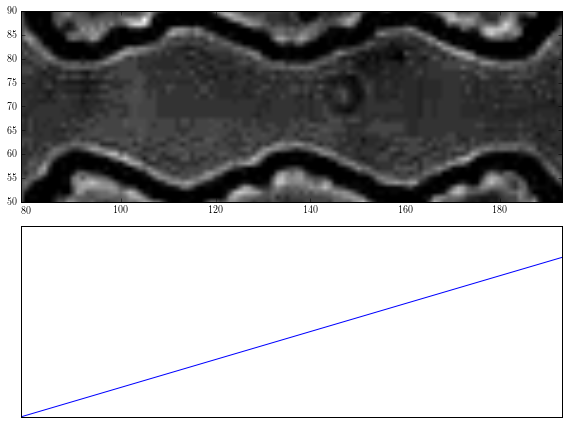

In [239]:
fig = plt.figure(figsize=(8, 6))



ax0 = fig.add_subplot(2,1,1)
plt.gca()

plt.imshow(frame, cmap = 'gray', aspect = 'auto', origin = 'lower')
plt.xlim(79,193)
plt.ylim(50,90)

#ax0.get_xaxis().set_ticks([])
#ax0.get_yaxis().set_ticks([])

ax1 = fig.add_subplot(2,1,2)
plt.gca()

plt.plot([1,2],[2,3])

plt.xlim(1,2)

ax1.get_xaxis().set_ticks([])
ax1.get_yaxis().set_ticks([])

plt.tight_layout()